# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#Importing Libraries
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, countDistinct
from pyspark.sql.functions import isnull, when, count, col
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, GBTClassifier, DecisionTreeClassifier, NaiveBayes

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Loading the mini sparkify dataset
sparkify_mini_dataset = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_mini_dataset)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

### Checking for Empty User ids and Session Ids

In [4]:
# Number of records in the dataset
df.count()

286500

In [5]:
#There seems to be no na or null values for sessionId and UserId
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
#Checking for Empty Values in userId
from pyspark.sql.functions import isnan
df.filter((df["userId"] == "") | df["UserId"].isNull() | isnan(df["UserId"])).count()

8346

In [7]:
#Checking for Empty Values in sessionId
from pyspark.sql.functions import isnan
df.filter((df["sessionId"] == "") | df["sessionId"].isNull() | isnan(df["sessionId"])).count()

0

In [8]:
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Analysing data for users who cancelled sparkify

In [9]:
df.select("page").distinct().show(100,False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [10]:
#Focusing on users under "Cancellation Confirmation"
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [11]:
#Having a look at a customer who cancelled
df.select(["userId", "page", "gender", "level", "song", "sessionId","ts"]).where(df.userId == "125").show(10, False)

+------+-----------+------+-----+-----------------------------+---------+-------------+
|userId|page       |gender|level|song                         |sessionId|ts           |
+------+-----------+------+-----+-----------------------------+---------+-------------+
|125   |NextSong   |M     |free |paranoid android             |174      |1539317144000|
|125   |NextSong   |M     |free |Hypnotize(Album Version)     |174      |1539317481000|
|125   |NextSong   |M     |free |I'm On My Way                |174      |1539317711000|
|125   |NextSong   |M     |free |Leader Of Men (Album Version)|174      |1539317914000|
|125   |NextSong   |M     |free |Love You Down                |174      |1539318124000|
|125   |NextSong   |M     |free |Don't Leave Me Behind        |174      |1539318515000|
|125   |NextSong   |M     |free |They're Red Hot              |174      |1539318728000|
|125   |NextSong   |M     |free |Kota                         |174      |1539318906000|
|125   |Roll Advert|M     |free 

In [12]:
#Ts is not really readable in the above table
#Adjusting TS format to make it readable
timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", timestamp(df.ts))

In [13]:
df.select(["userId", "page", "gender", "level", "song", "sessionId","time"]).where(df.userId == "125").show(10, False)

+------+-----------+------+-----+-----------------------------+---------+-------------------+
|userId|page       |gender|level|song                         |sessionId|time               |
+------+-----------+------+-----+-----------------------------+---------+-------------------+
|125   |NextSong   |M     |free |paranoid android             |174      |2018-10-12 04:05:44|
|125   |NextSong   |M     |free |Hypnotize(Album Version)     |174      |2018-10-12 04:11:21|
|125   |NextSong   |M     |free |I'm On My Way                |174      |2018-10-12 04:15:11|
|125   |NextSong   |M     |free |Leader Of Men (Album Version)|174      |2018-10-12 04:18:34|
|125   |NextSong   |M     |free |Love You Down                |174      |2018-10-12 04:22:04|
|125   |NextSong   |M     |free |Don't Leave Me Behind        |174      |2018-10-12 04:28:35|
|125   |NextSong   |M     |free |They're Red Hot              |174      |2018-10-12 04:32:08|
|125   |NextSong   |M     |free |Kota                       

### Flagging churn customers from population

In [14]:
#Selecting customer with page = "Cancellation Confirmation"
churned_users = df.filter(df.page=="Cancellation Confirmation").select("userId")
#dedup
chunder_users_dd=churned_users.dropDuplicates()
users = [(row['userId']) for row in chunder_users_dd.collect()]
df = df.withColumn("churn", df.userId.isin(users))

In [15]:
#True and false distribution for churn
df.groupBy('churn').agg(countDistinct("userId")).show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
| true|                    52|
|false|                   173|
+-----+----------------------+



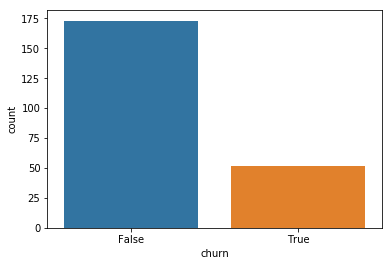

In [16]:
df_barchart = df.dropDuplicates(["userId", "churn"]).groupby(["churn"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', data=df_barchart)

In [17]:
churned = df.filter(df.churn==1).count()
not_churned = df.filter(df.churn==0).count()

### Studying variables based on churn column

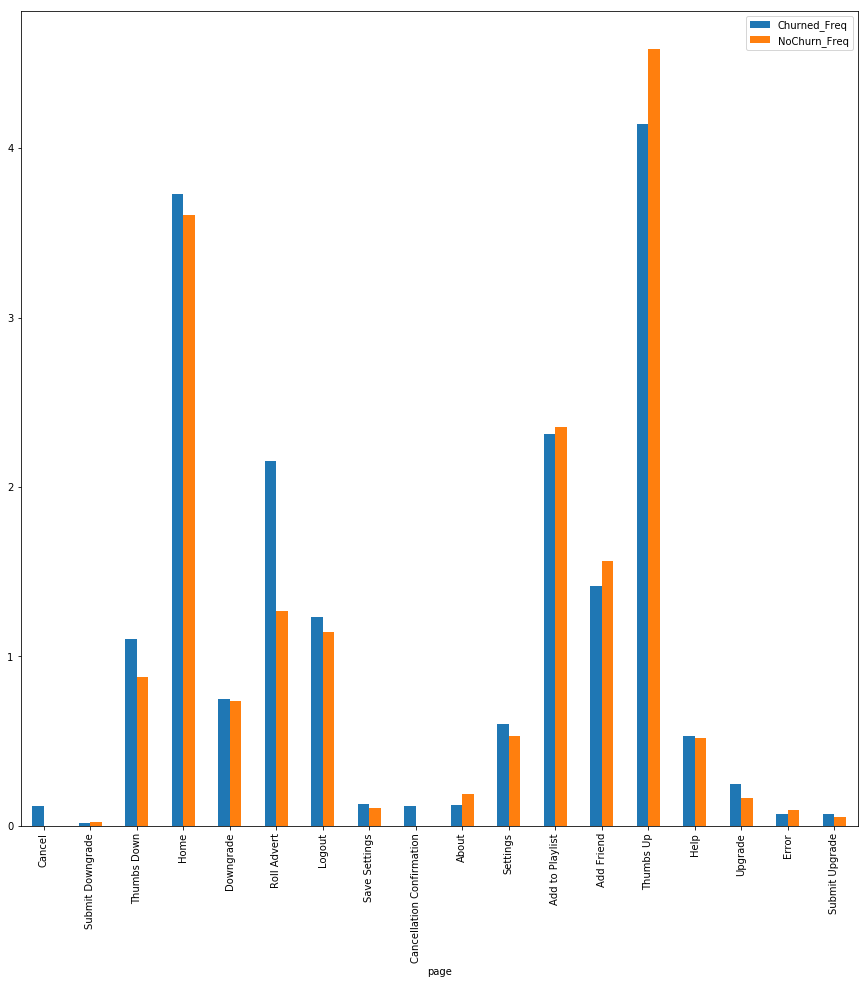

In [18]:
#Studying which pages churned users have used vs non churned
page_count_churn = df.filter(df.churn==1).filter(df.page!="NextSong").groupby(["page"]).count()
df_churned_bypage = page_count_churn.withColumn("Churned_Freq", page_count_churn["count"]/(churned/100)).sort("page")

page_count_nochurn = df.filter(df.churn==0).filter(df.page!="NextSong").groupby(["page"]).count()
df_nchurned_bypage = page_count_nochurn.withColumn("NoChurn_Freq", page_count_nochurn["count"]/(not_churned/100)).sort("page")

df_to_plot = df_churned_bypage.join(df_nchurned_bypage, "page", "outer").drop("count").fillna(0).toPandas()
df_to_plot.plot.bar("page",figsize=(15,15))

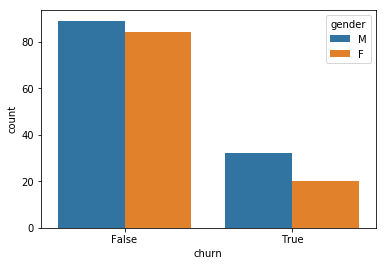

In [19]:
# Males and Females ratio
df_to_plot = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_to_plot)

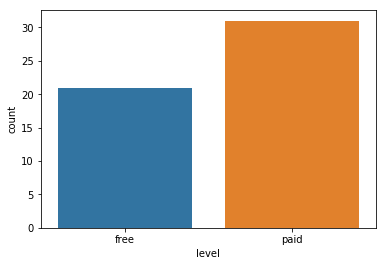

In [20]:
#Paid VS Free
df_to_plot = df.filter(df.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_to_plot)

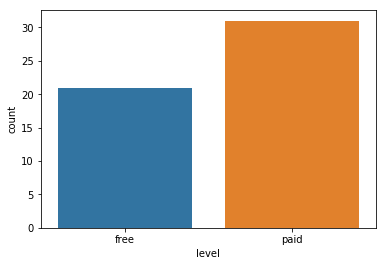

In [21]:
#Thumbs up Vs Thumbs Down
df_to_plot = df.filter(df.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_to_plot)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
#Feature n1: Gender
#Converting Gender to numeric
Feature_n1 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
Feature_n1.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



In [23]:
#Feature n2: Total time spent listening for all services
Feature_n2 = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time_listened')
Feature_n2.show(5)

+------+-------------------+
|userId|total_time_listened|
+------+-------------------+
|100010|  66940.89735000003|
|200002|  94008.87593999993|
|   125| 2089.1131000000005|
|    51|  523275.8428000004|
|   124| 1012312.0927899999|
+------+-------------------+
only showing top 5 rows



In [24]:
# Feature n3 : Number of thumbs down
Feature_n3 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_down')
Feature_n3.show(5)

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
+------+-----------------+
only showing top 5 rows



In [25]:
# Feature n4 : Number of thumbs up
Feature_n4 = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_up')
Feature_n4.show(5)

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
+------+---------------+
only showing top 5 rows



In [26]:
# Feature n5 : User Churn
Feature_churn = df.select("userId", "churn").dropDuplicates()
Feature_n5 = df.select("userId", Feature_churn.churn.cast("int"))
Feature_n5.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    30|    0|
|     9|    0|
|    30|    0|
|     9|    0|
|    30|    0|
+------+-----+
only showing top 5 rows



In [27]:
# Feature n6: Average number of songs listend per session
user_by_session = df.filter(df.page=="NextSong").groupby("userId", "sessionId").count()
Feature_n6 = user_by_session.groupby("userId").agg(avg(user_by_session["count"]).alias("Average_Song_Count")).sort("userId")
Feature_n6.show(5)

+------+------------------+
|userId|Average_Song_Count|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



In [28]:
#Feature n7: Number of Artists Listened
artist_by_user=df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
Feature_n7 = artist_by_user.withColumnRenamed("count", "Total_Artists_Listened")
Feature_n7.show(5)

+------+----------------------+
|userId|Total_Artists_Listened|
+------+----------------------+
|100010|                   252|
|200002|                   339|
|   125|                     8|
|    51|                  1385|
|   124|                  2232|
+------+----------------------+
only showing top 5 rows



In [29]:
#Feature n8: Days since registered
max_timestamp = df.groupby("userId").max("ts").sort("userId")
users_by_registration = df.select("userId", "registration").dropDuplicates().sort("userId")
df_joined=users_by_registration.join(max_timestamp, users_by_registration.userId == max_timestamp.userId)
Feature_n8 = df_joined.select(users_by_registration["userId"], ((max_timestamp["max(ts)"]-users_by_registration["registration"])/(1000*60*60*24)).cast('integer').alias("Days_Since_Registration"))

Feature_n8.show(5)

+------+-----------------------+
|userId|Days_Since_Registration|
+------+-----------------------+
|100010|                     55|
|200002|                     70|
|   125|                     71|
|   124|                    131|
|    51|                     19|
+------+-----------------------+
only showing top 5 rows



In [30]:
#Feature n9: Number of Sessions
Feature_n9 = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "Number_of_Sessions")
Feature_n9.show(5)

+------+------------------+
|userId|Number_of_Sessions|
+------+------------------+
|100010|                 7|
|200002|                 6|
|   125|                 1|
|    51|                10|
|   124|                29|
+------+------------------+
only showing top 5 rows



In [31]:
#Feature n10: User Level
#extract level feature
Feature_n10 = df.dropDuplicates(['userId']).select(['userId','level']).replace(['paid','free'], ['1', '0'])
Feature_n10 = Feature_n10.withColumn('level', Feature_n10.level.cast("float"))
Feature_n10.show(10)

+------+-----+
|userId|level|
+------+-----+
|100010|  0.0|
|200002|  0.0|
|   125|  0.0|
|   124|  1.0|
|    51|  1.0|
|     7|  0.0|
|    15|  1.0|
|    54|  1.0|
|   155|  0.0|
|100014|  1.0|
+------+-----+
only showing top 10 rows



In [32]:
# Merging all features by userId to create the features dataset

features_dataset = Feature_n1.join(Feature_n2, 'userId', 'inner').join(Feature_n3, 'userId', 'inner').join(Feature_n4, 'userId', 'inner')\
             .join(Feature_n10, 'userId', 'inner').join(Feature_n6, 'userId', 'inner').join(Feature_n7, 'userId', 'inner')\
             .join(Feature_n8, 'userId', 'inner').join(Feature_n9, 'userId', 'inner').join(Feature_n5, 'userId', 'inner').drop("userId")

features_dataset.show(5)

+------+-------------------+-----------------+---------------+-----+------------------+----------------------+-----------------------+------------------+-----+
|gender|total_time_listened|total_thumbs_down|total_thumbs_up|level|Average_Song_Count|Total_Artists_Listened|Days_Since_Registration|Number_of_Sessions|churn|
+------+-------------------+-----------------+---------------+-----+------------------+----------------------+-----------------------+------------------+-----+
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|                   252|                     55|                 7|    0|
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|                   252|                     55|                 7|    0|
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|                   252|                     55|                 7|    0|
|     0|  66940.89735000003|            

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [33]:
#Putting features to be trained in a vector
assembler = VectorAssembler(inputCols=features_dataset.columns[0:-1], outputCol="Features")
data = assembler.transform(features_dataset)

In [34]:
data.show(5)

+------+-------------------+-----------------+---------------+-----+------------------+----------------------+-----------------------+------------------+-----+--------------------+
|gender|total_time_listened|total_thumbs_down|total_thumbs_up|level|Average_Song_Count|Total_Artists_Listened|Days_Since_Registration|Number_of_Sessions|churn|            Features|
+------+-------------------+-----------------+---------------+-----+------------------+----------------------+-----------------------+------------------+-----+--------------------+
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|                   252|                     55|                 7|    0|[0.0,66940.897350...|
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|                   252|                     55|                 7|    0|[0.0,66940.897350...|
|     0|  66940.89735000003|                5|             17|  0.0|39.285714285714285|        

In [35]:
features_dataset.columns[0:-1]

['gender',
 'total_time_listened',
 'total_thumbs_down',
 'total_thumbs_up',
 'level',
 'Average_Song_Count',
 'Total_Artists_Listened',
 'Days_Since_Registration',
 'Number_of_Sessions']

In [36]:
#running standard scaler with "withStd=True" to standardise features
scaler = StandardScaler(inputCol="Features", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [37]:
#Selecting Churn and features and renaming to run our models
data = data.select(data.churn.alias('label'), data.ScaledFeatures.alias('features'))
data.show(5, False)

+-----+-----------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                       |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0.0,0.1550619159214412,0.25951960431973276,0.16805123840296501,0.0,0.9779467094408741,0.3268700195848462,1.3608463664364845,0.281695302605458]|
|0    |[0.0,0.1550619159214412,0.25951960431973276,0.16805123840296501,0.0,0.9779467094408741,0.3268700195848462,1.3608463664364845,0.281695302605458]|
|0    |[0.0,0.1550619159214412,0.25951960431973276,0.16805123840296501,0.0,0.9779467094408741,0.3268700195848462,1.3608463664364845,0.281695302605458]|
|0    |[0.0,0.1550619159214412,0.25951960431973276,0.16805123840296501,0.0,0.97794670944

### Creating training and validation sets

In [38]:
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

# Comparing GBT VS SVM Classification Models to get best F1 Score and Accuracy

In [39]:
#GBT
GBT_Classifier = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')
param = ParamGridBuilder().build()
crossv_gbt = CrossValidator(estimator = GBT_Classifier, estimatorParamMaps = param, evaluator = f1_score, numFolds = 2)
gbt_model = crossv_gbt.fit(train)

In [40]:
gbt_model.avgMetrics

[0.9997384516875645]

In [41]:
# GBT Evaluation Metrics
gbt_results = gbt_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("GBT F1 score {} ".format(evaluator.evaluate(gbt_results, {evaluator.metricName : "f1"})))
print("GBT Accuracy {} ".format(evaluator.evaluate(gbt_results, {evaluator.metricName : "accuracy"})))

GBT F1 score 0.9996389569516095 
GBT Accuracy 0.9996391194514616 


In [42]:
#SVM
SVM_Classifier = LinearSVC(maxIter = 15)
f1_score = MulticlassClassificationEvaluator(metricName = 'f1')
param = ParamGridBuilder().build()
crossv_svm = CrossValidator(estimator = SVM_Classifier, estimatorParamMaps = param, evaluator = f1_score, numFolds = 2)
svm_model = crossv_svm.fit(train)

In [43]:
svm_model.avgMetrics

[0.7651044593904157]

In [44]:
# SVM Evaluation Metrics
svm_results = svm_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("SVM F1 score {}".format(evaluator.evaluate(svm_results, {evaluator.metricName : "f1"})))
print("SVM accuracy {}".format(evaluator.evaluate(svm_results, {evaluator.metricName : "accuracy"})))

SVM F1 score 0.7642927352706442
SVM accuracy 0.8381089859256586


Besides taking a longer run time, GBT boasts an astonishing F1 Score of 0.99 and accuracy of 0.99 compared to the 0.76 F1 and 0.83 accuracy of SVM

### Results

We have studied the sparkify mini dataset, cleaned and analysed the dataset and we came up with 9 features to use for our models. We compared the "Support Vector Machine" (SVM) versus the "Gradient Boosting Trees" (GBT) models and chose to utilise GBT to predict churn due to its perfect accuracy and F1 score of 0.99.

### Improvements
Here are a few ways this model can be improved:

1- For this analysis we used the mini sparkify dataset however exploring the bigger Sparkify dataset might be interesting to see if we can come with the same accuracy.

2- The model could be trained for a few weeks and used to predict the chance of users churning in the future. The population of users churning identified by the model can then be targeted with messages and offers.

3- We could take another approach and find out the users who are going to downgrade from paid to free and target those with additional offers or try to identify the factors that are leading to the downgrades